### Importing Libraries and Setting Up Device

1. **Import Libraries**  
   - `torch` and `torch.nn`: Core PyTorch libraries for model building and computations.  
   - `transformers`: Provides pre-trained models and tokenizers.  
   - `sklearn.metrics`: For model evaluation metrics such as accuracy, precision, recall, F1-score, and classification reports.  
   - `torch.utils.data`: Tools for creating and loading datasets.  
   - `tqdm`: For progress bars during training and evaluation loops.  
   - `matplotlib.pyplot`: For visualizing results and performance.

2. **GPU Check**  
   - Determines whether a GPU is available and sets the computation device accordingly:  
     - `cuda` if a GPU is available.  
     - `cpu` otherwise.  
   - Prints the selected device for confirmation.

This setup ensures compatibility and efficiency for training and evaluating deep learning models using PyTorch and Transformers.

In [42]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(f"Using device: {device}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Using device: cuda


### Example Data Preparation

1. **Dataset Loading**  
   - Using the `datasets` library to load the **TweetEval dataset** for the "hate speech" classification task.
   - The dataset is split into `train`, `validation`, and `test` sets.

2. **Data Splits**  
   - `train_texts` and `train_labels`: Training data.  
   - `val_texts` and `val_labels`: Validation data for tuning.  
   - `test_texts` and `test_labels`: Testing data for evaluation.  
   - The sizes of each split are printed for verification.

3. **Text Preprocessing**  
   - A custom function, `preprocess_text`, cleans the text by:  
     - Converting to lowercase.  
     - Removing URLs, mentions (`@`), hashtags (`#`), and non-alphabetic characters.  
     - Removing extra spaces.  
   - Preprocessing is applied to all text splits: `train_texts`, `val_texts`, and `test_texts`.

This step prepares the data for input into models while ensuring consistency and noise reduction.

In [43]:
# Example data preparation (Replace with your dataset loading logic)
from datasets import load_dataset

# Load the TweetEval dataset for hate speech
dataset = load_dataset("cardiffnlp/tweet_eval", "hate")

# Split data into train, validation, and test sets
train_texts, train_labels = dataset['train']['text'], dataset['train']['label']
val_texts, val_labels = dataset['validation']['text'], dataset['validation']['label']
test_texts, test_labels = dataset['test']['text'], dataset['test']['label']

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|\#\w+|[^a-zA-Z\s]', '', text)
    return ' '.join(text.split())

# Apply preprocessing
train_texts = [preprocess_text(text) for text in train_texts]
val_texts = [preprocess_text(text) for text in val_texts]
test_texts = [preprocess_text(text) for text in test_texts]

Train size: 9000, Validation size: 1000, Test size: 2970


class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2, dropout_rate=0.3):
        super(TransformerClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token representation for classification
        pooled_output = outputs.pooler_output
        
        # Apply dropout and classification layer
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        
        return logits

### Custom Dataset and BERT Classifier Definition

1. **Custom Dataset Class**  
   - `TextDataset`: A PyTorch dataset for tokenized text data.  
   - Key Features:  
     - Tokenizes input texts using `tokenizer.encode_plus`.  
     - Handles padding, truncation, and attention masks.  
     - Returns token IDs, attention masks, and labels.  

2. **BERT-Based Classifier**  
   - `BERTClassifier`: A text classification model using a pre-trained BERT backbone.  
   - Key Features:  
     - Includes BERT as the base model.  
     - Adds a dropout layer (rate: 0.3) and a classification head.  
     - Outputs class logits from the pooled BERT representation.

These components prepare the data and define the architecture for text classification tasks.

In [44]:
# Define a PyTorch Dataset class for tokenized text data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), torch.tensor(label)

# Define the BERT-based classifier model
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        return self.classifier(dropout_output)

### Model Evaluation and Training

1. **Evaluation Function**  
   - `evaluate_model`: Computes metrics for model performance on a dataset.  
   - Metrics: Accuracy, F1 score, precision, recall, and a detailed classification report.  
   - Uses a `DataLoader` for batch evaluation with GPU/CPU handling.

2. **Training Function**  
   - `train_model_with_metrics`: Trains the model and evaluates on validation data after each epoch.  
   - Key Features:  
     - Tracks training/validation accuracy and F1 scores.  
     - Early stopping implemented with patience based on validation F1 score.  
     - Uses `AdamW` optimizer and `CrossEntropyLoss`.  
     - Displays progress with `tqdm` for training and validation phases.

In [45]:
# Define evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "classification_report": report
    }

# Training function with tqdm progress bar
def train_model_with_metrics(model, train_dataloader, val_dataloader, epochs=1, patience=2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    best_val_f1 = 0
    patience_counter = 0

    metrics_history = {
        'train_accuracy': [],
        'train_f1': [],
        'val_accuracy': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        train_preds, train_labels = [], []

        print(f"\nEpoch {epoch + 1}/{epochs}")
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate and store training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds)
        metrics_history['train_accuracy'].append(train_accuracy)
        metrics_history['train_f1'].append(train_f1)

        # Validation phase
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validating"):
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score


### Plotting Training Metrics
- **Function**: `plot_metrics` visualizes the training and validation accuracy and F1 score over epochs.
- **Key Features**:  
  - Separate plots for accuracy and F1 score.  
  - Includes markers for data points and legends for clarity.  
  - Automatically adjusts layout for readability.
- **Usage**: Analyze the model's performance trends over epochs.

In [46]:
# Plot the metrics over epochs
def plot_metrics(metrics_history, model_name):
    epochs = range(1, len(metrics_history['train_accuracy']) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics_history['train_accuracy'], label='Train Accuracy', marker='o')
    plt.plot(epochs, metrics_history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'{model_name} - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_history['train_f1'], label='Train F1-Score', marker='o')
    plt.plot(epochs, metrics_history['val_f1'], label='Validation F1-Score', marker='o')
    plt.title(f'{model_name} - F1 Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


### Model Evaluation and Testing Workflow
- **Evaluation Function**: `evaluate_model` computes accuracy, F1 score, precision, recall, and generates a classification report on the test set.
- **Main Steps**:
  1. **Model Initialization**: Load a pre-trained BERT model (`bert-base-uncased`) for classification.
  2. **Training**: Train the model using the `train_model` function with specified epochs.
  3. **Best Model Loading**: Load the best-performing model from `bert_best_model.pt`.
  4. **Test Evaluation**: Evaluate the model on the test set and compute detailed metrics.
  5. **Confusion Matrix**: Plot the confusion matrix for true vs. predicted labels.
  6. **Save Predictions**: Save results to `hate_speech_predictions.csv`.
  7. **Example Predictions**: Print a few sample predictions alongside true labels.
- **Visualization**: Includes a heatmap for the confusion matrix.
- **Output**: Metrics, detailed classification report, and example predictions.

Initializing BERT model...

Starting training...

Epoch 1/3



Average training loss: 0.5042
Training Accuracy: 0.7437
Training F1: 0.6799
Average validation loss: 0.4926
Validation Accuracy: 0.7640
Validation F1: 0.7230
Saved new best model!

Epoch 2/3



Average training loss: 0.3432
Training Accuracy: 0.8548
Training F1: 0.8288
Average validation loss: 0.4843
Validation Accuracy: 0.7740
Validation F1: 0.7559
Saved new best model!

Epoch 3/3



Average training loss: 0.2447
Training Accuracy: 0.9064
Training F1: 0.8892
Average validation loss: 0.5218
Validation Accuracy: 0.7780
Validation F1: 0.7582
Saved new best model!

Loading best model for evaluation...


/tmp/ipykernel_23/3275069897.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bert_best_model.pt'))



Evaluating on test set...



Test Set Results:
Accuracy: 0.5178
F1-Score: 0.6305
Precision: 0.4657
Recall: 0.9760

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.18      0.31      1718
           1       0.47      0.98      0.63      1252

    accuracy                           0.52      2970
   macro avg       0.69      0.58      0.47      2970
weighted avg       0.72      0.52      0.44      2970



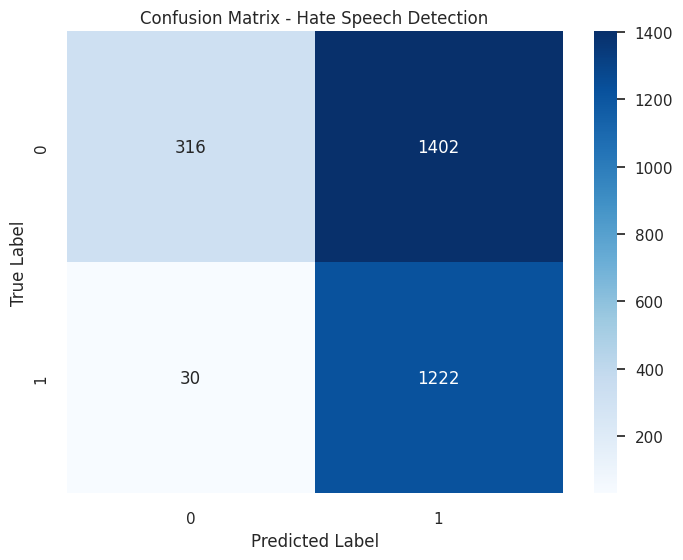


Example Predictions:

Tweet: trump pentagon will build walltrump says he could use the military to build his wall if congress wont fund it through homeland securitys budget
True Label: 0
Predicted: 1

Tweet: the latest pundits post w articles tweeted by
True Label: 0
Predicted: 1

Tweet: i hate a bitch that think she know me friend or not bitch you only know what i tell you speak on what tf you know hoe
True Label: 1
Predicted: 1

Tweet: ur vids are great but learn to not be an asshole off camera bitch
True Label: 0
Predicted: 1

Tweet: correct title sc cracks down on illegal aliens commiting crimes stealing ids ssn or using fake ones felon to take jobs from americans illegals not above us laws via
True Label: 1
Predicted: 1


In [47]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            # Correct way to access batch data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'f1': f1_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions),
        'recall': recall_score(true_labels, predictions),
        'classification_report': classification_report(true_labels, predictions),
        'true_labels': true_labels,
        'predictions': predictions
    }

# Main execution code
print("Initializing BERT model...")
model = BERTClassifier('bert-base-uncased').to(device)

print("\nStarting training...")
train_model(model, train_dataloader, val_dataloader, epochs=3)

# Load best model for evaluation
print("\nLoading best model for evaluation...")
model.load_state_dict(torch.load('bert_best_model.pt'))

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = evaluate_model(model, test_dataloader)

# Print detailed results
print("\nTest Set Results:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"F1-Score: {test_results['f1']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")

print("\nDetailed Classification Report:")
print(test_results['classification_report'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(test_results['true_labels'], test_results['predictions']),
    annot=True, 
    fmt='d',
    cmap='Blues'
)
plt.title('Confusion Matrix - Hate Speech Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save results
results_df = pd.DataFrame({
    'True_Labels': test_results['true_labels'],
    'Predictions': test_results['predictions']
})
results_df.to_csv('hate_speech_predictions.csv', index=False)

# Print example predictions
print("\nExample Predictions:")
sample_indices = np.random.randint(0, len(test_texts), 5)
for idx in sample_indices:
    print(f"\nTweet: {test_texts[idx]}")
    print(f"True Label: {test_results['true_labels'][idx]}")
    print(f"Predicted: {test_results['predictions'][idx]}")

### BERT Model Workflow: Initialization, Training, Evaluation
1. **Tokenizer Initialization**: Use `AutoTokenizer` from `bert-base-uncased`.
2. **Dataset Preparation**:
   - Create datasets (`TextDataset`) for training, validation, and testing.
   - Load datasets into `DataLoader` with appropriate batch sizes.
3. **Model Initialization**: Load `BERTClassifier` with pre-trained `bert-base-uncased`.
4. **Model Training**:
   - Train the model using `train_model_with_metrics` for 3 epochs with early stopping.
   - Plot training and validation metrics (accuracy, F1-score).
5. **Evaluation Function**: Define `evaluate_final` to compute metrics including accuracy, F1, precision, recall, and generate a classification report.
6. **Test Set Evaluation**:
   - Evaluate the model on test data.
   - Display metrics, classification report, and confusion matrix (visualized with `sns.heatmap`).
7. **Save Predictions**:
   - Save predictions to `hate_speech_predictions.csv`.
   - Print random example predictions for review.
8. **Save Final Model**: Export trained model as `bert_final_model.pt`.

### Outputs:
- Metrics: Accuracy, F1, precision, recall.
- Confusion Matrix: Visual representation of model predictions.
- Saved Artifacts: Predictions CSV and trained model.

Initializing BERT model...

Training BERT Classifier...

Epoch 1/3


Validating: 100%|██████████| 63/63 [00:03<00:00, 17.18it/s]



Epoch 2/3


Validating: 100%|██████████| 63/63 [00:03<00:00, 17.27it/s]



Epoch 3/3


Validating: 100%|██████████| 63/63 [00:03<00:00, 17.37it/s]



Evaluating BERT on Test Data...



Test Results:
Accuracy: 0.5825
F1-Score: 0.6507
Precision: 0.5026
Recall: 0.9225

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.33      0.48      1718
           1       0.50      0.92      0.65      1252

    accuracy                           0.58      2970
   macro avg       0.68      0.63      0.57      2970
weighted avg       0.71      0.58      0.55      2970



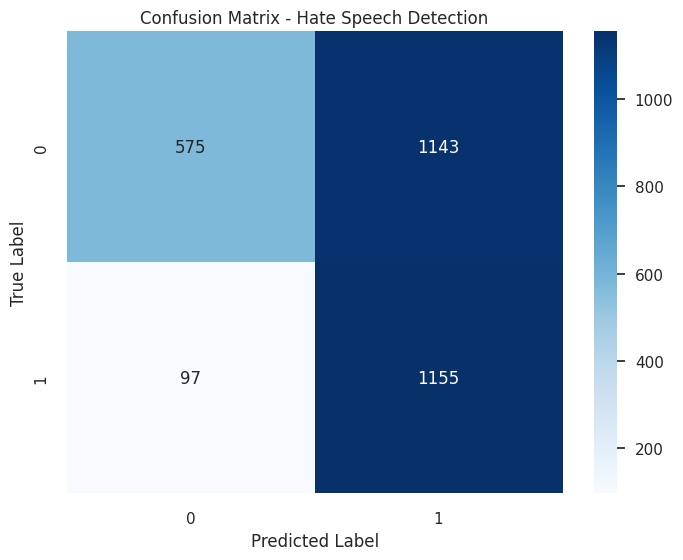


Example Predictions:

Tweet: sen booker posted the confidential information on his twitter account there is no way i will vote democrat again disregard for the laws when it suits them and he wants to run for potus
True Label: 0
Predicted: 1

Tweet: idk id rather die than be sentenced life in jail and become someones bitch who rapes me
True Label: 0
Predicted: 1

Tweet: i am thrilled to see following our campaign retweets in daysmr president i am going work with you to cut taxes even more bring back manufacturing fix our healthcare
True Label: 0
Predicted: 1

Tweet: our beautiful flotus strongly calls out nyt anonymous writer as sabotaging our country
True Label: 0
Predicted: 1

Tweet: your spurious and dullwitted comments using strawman arguments and red herrings cloud the issue of next time make sure you know what youre talking about dont use emotion to trump facts when you cant debate my tweets
True Label: 0
Predicted: 0

Model saved as 'bert_final_model.pt'


In [55]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Prepare datasets
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Initialize model
print("Initializing BERT model...")
bert_model = BERTClassifier('bert-base-uncased').to(device)

# Train model
print("\nTraining BERT Classifier...")
metrics_history = train_model_with_metrics(
    bert_model, 
    train_dataloader, 
    val_dataloader, 
    epochs=3, 
    patience=2
)

# Plot training metrics if available
if metrics_history:
    plot_metrics(metrics_history, "BERT")

# Define evaluation function with correct batch access
def evaluate_final(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'f1': f1_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions),
        'recall': recall_score(true_labels, predictions),
        'classification_report': classification_report(true_labels, predictions),
        'true_labels': true_labels,
        'predictions': predictions
    }

# Evaluate on test set
print("\nEvaluating BERT on Test Data...")
test_results = evaluate_final(bert_model, test_dataloader)

# Print results
print("\nTest Results:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"F1-Score: {test_results['f1']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print("\nClassification Report:")
print(test_results['classification_report'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(test_results['true_labels'], test_results['predictions']),
    annot=True, 
    fmt='d',
    cmap='Blues'
)
plt.title('Confusion Matrix - Hate Speech Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save results
results_df = pd.DataFrame({
    'True_Labels': test_results['true_labels'],
    'Predictions': test_results['predictions']
})
results_df.to_csv('hate_speech_predictions.csv', index=False)

# Print example predictions
print("\nExample Predictions:")
sample_indices = np.random.randint(0, len(test_texts), 5)
for idx in sample_indices:
    print(f"\nTweet: {test_texts[idx]}")
    print(f"True Label: {test_results['true_labels'][idx]}")
    print(f"Predicted: {test_results['predictions'][idx]}")

# Save the model
torch.save(bert_model.state_dict(), 'bert_final_model.pt')
print("\nModel saved as 'bert_final_model.pt'")